In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import shutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set_style('darkgrid')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
dir = r'/kaggle/input/lung-and-colon-data' 

file_paths = []
labels = []

for root, dirs, files in os.walk(dir):
    for classs in dirs:
        if classs in ["lung_image_sets", "colon_image_sets"]:
            continue  
        class_path = os.path.join(root, classs)
        flist = os.listdir(class_path)
        for f in flist:
            fpath = os.path.join(class_path, f)
            file_paths.append(fpath)
            labels.append(classs)

Fseries = pd.Series(file_paths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  

print(df['labels'].value_counts())

labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64


In [4]:
sample_size = 5000 
sample_list = []
group = df.groupby('labels')
for label in df['labels'].unique():    
    label_group = group.get_group(label).sample(sample_size, 
                                                replace=False, 
                                                random_state=42, 
                                                axis=0)
    sample_list.append(label_group)
df = pd.concat(sample_list, axis=0).reset_index(drop=True)
print(f"Total after sampling: {len(df)}")

Total after sampling: 25000


In [5]:
train_split = 0.8
test_split = 0.1
val_split = 1 - (train_split + test_split)

train_df, remaining_df = train_test_split(df, 
                                          train_size=train_split, 
                                          shuffle=True, 
                                          random_state=42)
test_df, valid_df = train_test_split(remaining_df, 
                                     train_size=test_split / (test_split + val_split), 
                                     shuffle=True, 
                                     random_state=42)

print(f"train_df: {len(train_df)}, test_df: {len(test_df)}, valid_df: {len(valid_df)}")

train_df: 20000, test_df: 2500, valid_df: 2500


In [6]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

In [7]:
height = 299
width = 299
channels = 3
batch_size = 32
img_size = (height, width)

In [8]:
def scalar(img):
    return (img / 127.5) - 1

def preprocess_image(file_path):
    img = Image.open(file_path).convert("RGB")
    transform = Compose([
        Resize(img_size),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(img)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.filepaths = dataframe['filepaths'].values
        self.labels = LabelEncoder().fit_transform(dataframe['labels'].values)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        label = self.labels[idx]
        image = preprocess_image(file_path)
        return image, label

In [10]:
length = len(test_df)
test_batch_size = max([
    int(length / n) 
    for n in range(1, length + 1) 
    if length % n == 0 and length / n <= 80
])
test_steps = length // test_batch_size
print('Test batch size:', test_batch_size, 'Test steps:', test_steps)

Test batch size: 50 Test steps: 50


In [11]:
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)
valid_dataset = CustomDataset(valid_df)

In [12]:
pin_mem = True if device.type == 'cuda' else False

In [13]:
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4,
                          pin_memory=pin_mem)

test_loader = DataLoader(test_dataset, 
                         batch_size=test_batch_size, 
                         shuffle=False, 
                         num_workers=4,
                         pin_memory=pin_mem)

valid_loader = DataLoader(valid_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4,
                          pin_memory=pin_mem)

In [14]:
classes = train_df['labels'].unique().tolist()
class_count = len(classes)
print(f"Found {len(train_dataset)} images for training belonging to {class_count} classes")
print(f"Found {len(test_dataset)} images for testing belonging to {class_count} classes")
print(f"Found {len(valid_dataset)} images for validating belonging to {class_count} classes")


Found 20000 images for training belonging to 5 classes
Found 2500 images for testing belonging to 5 classes
Found 2500 images for validating belonging to 5 classes


In [15]:
def display_image(loader,classes):
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()

    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 15)

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i].transpose(1, 2, 0) * 0.5) + 0.5  # Scale images between 0 and 1
        plt.imshow(image)
        class_name = classes[labels[i]]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

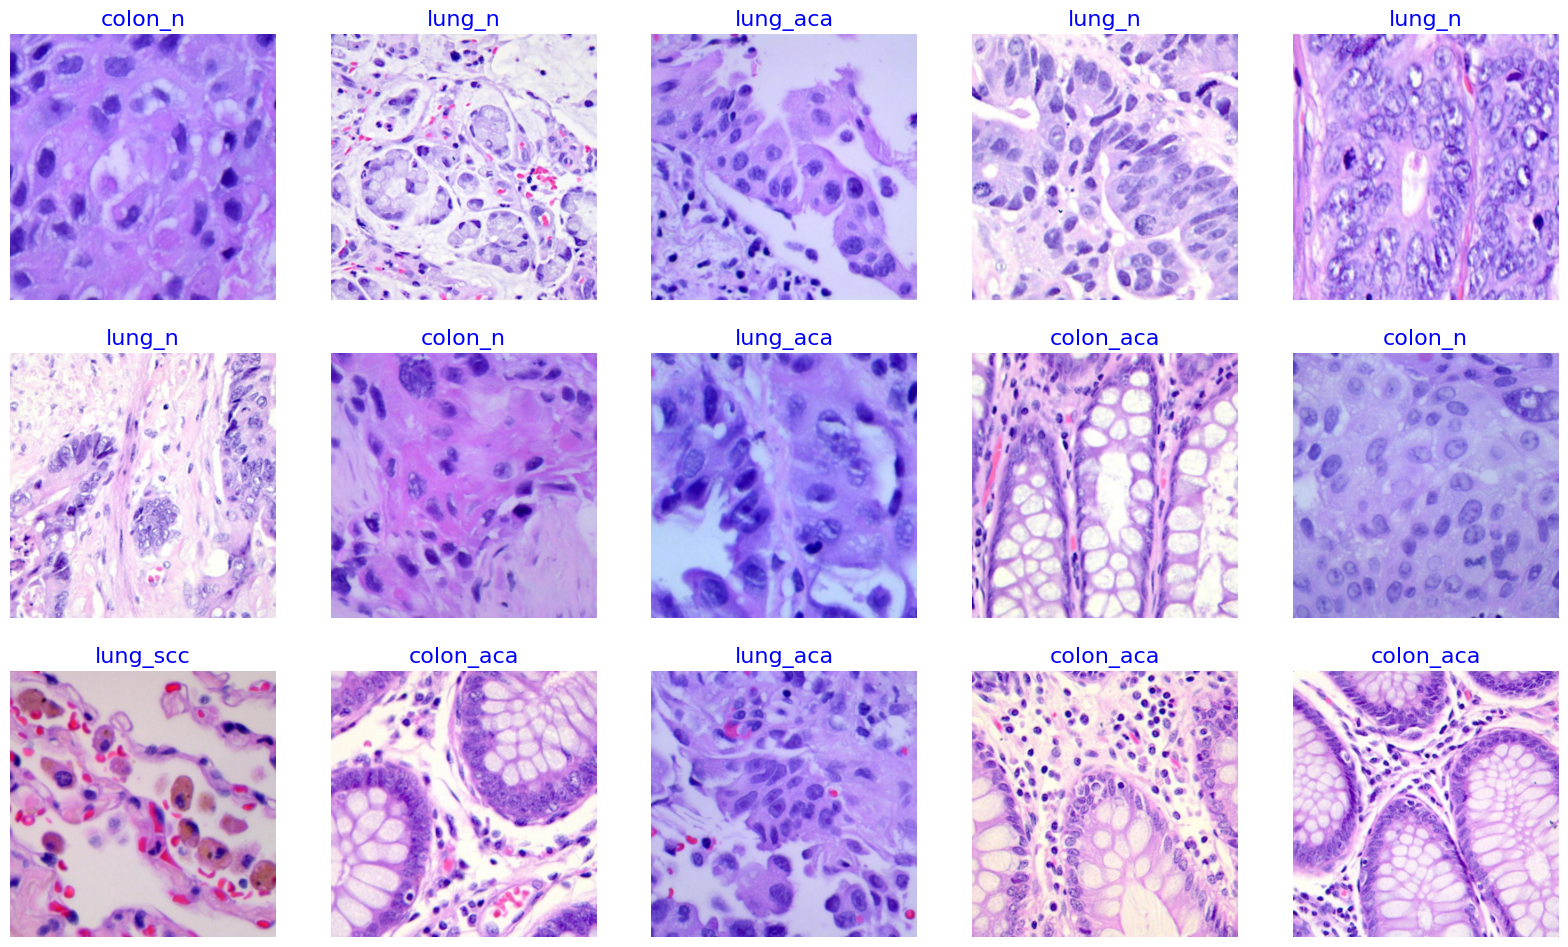

In [16]:
display_image(train_loader,classes)

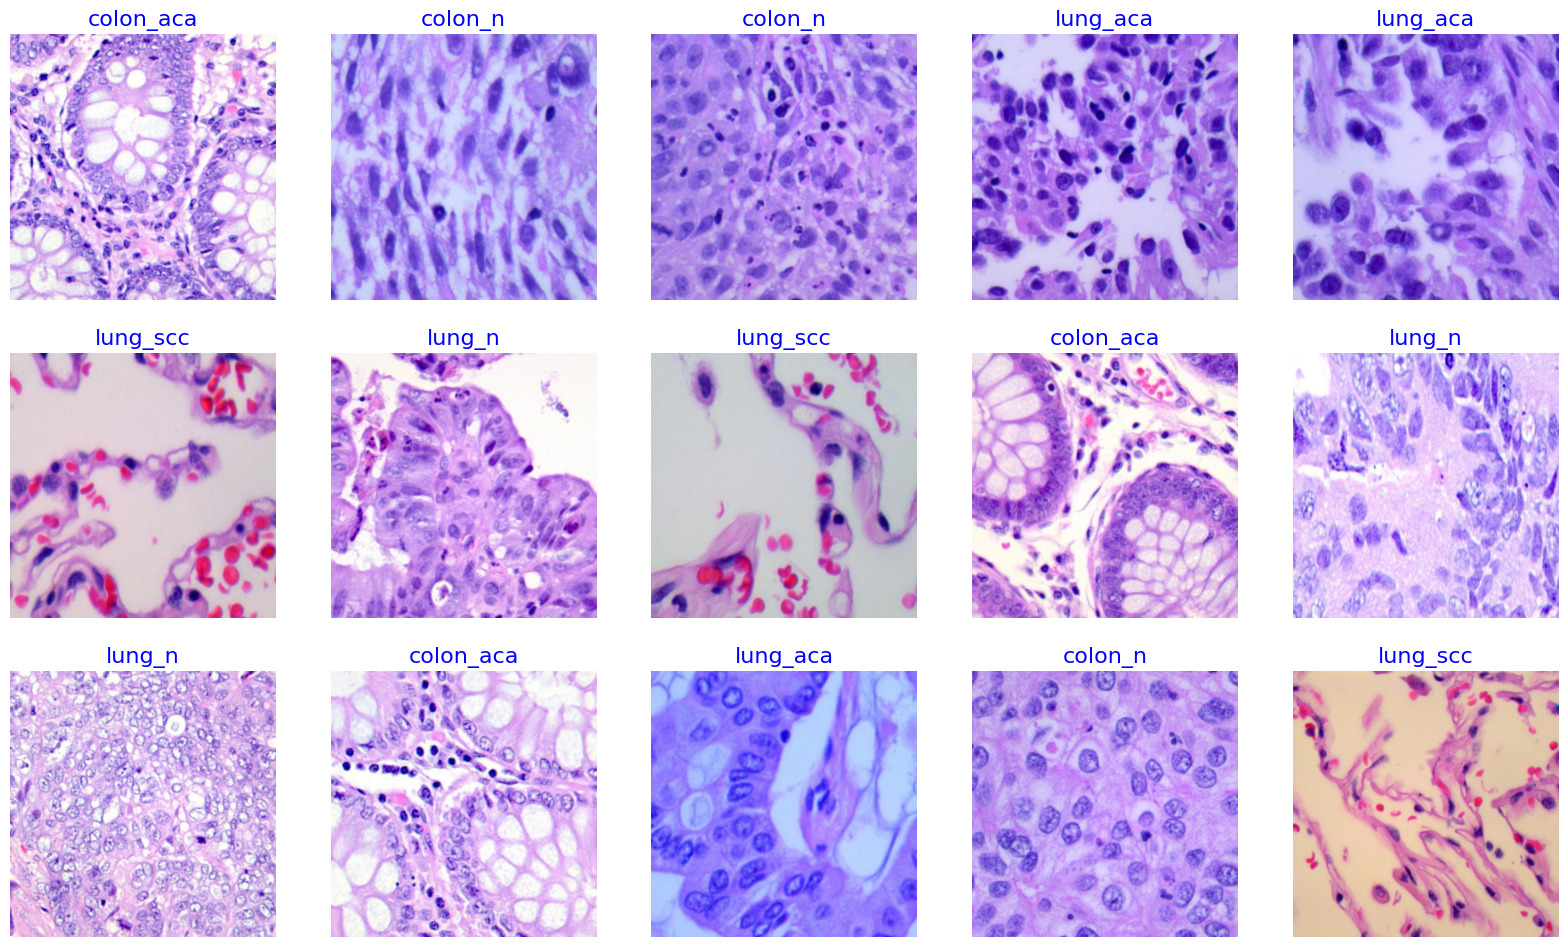

In [17]:
display_image(test_loader,classes)

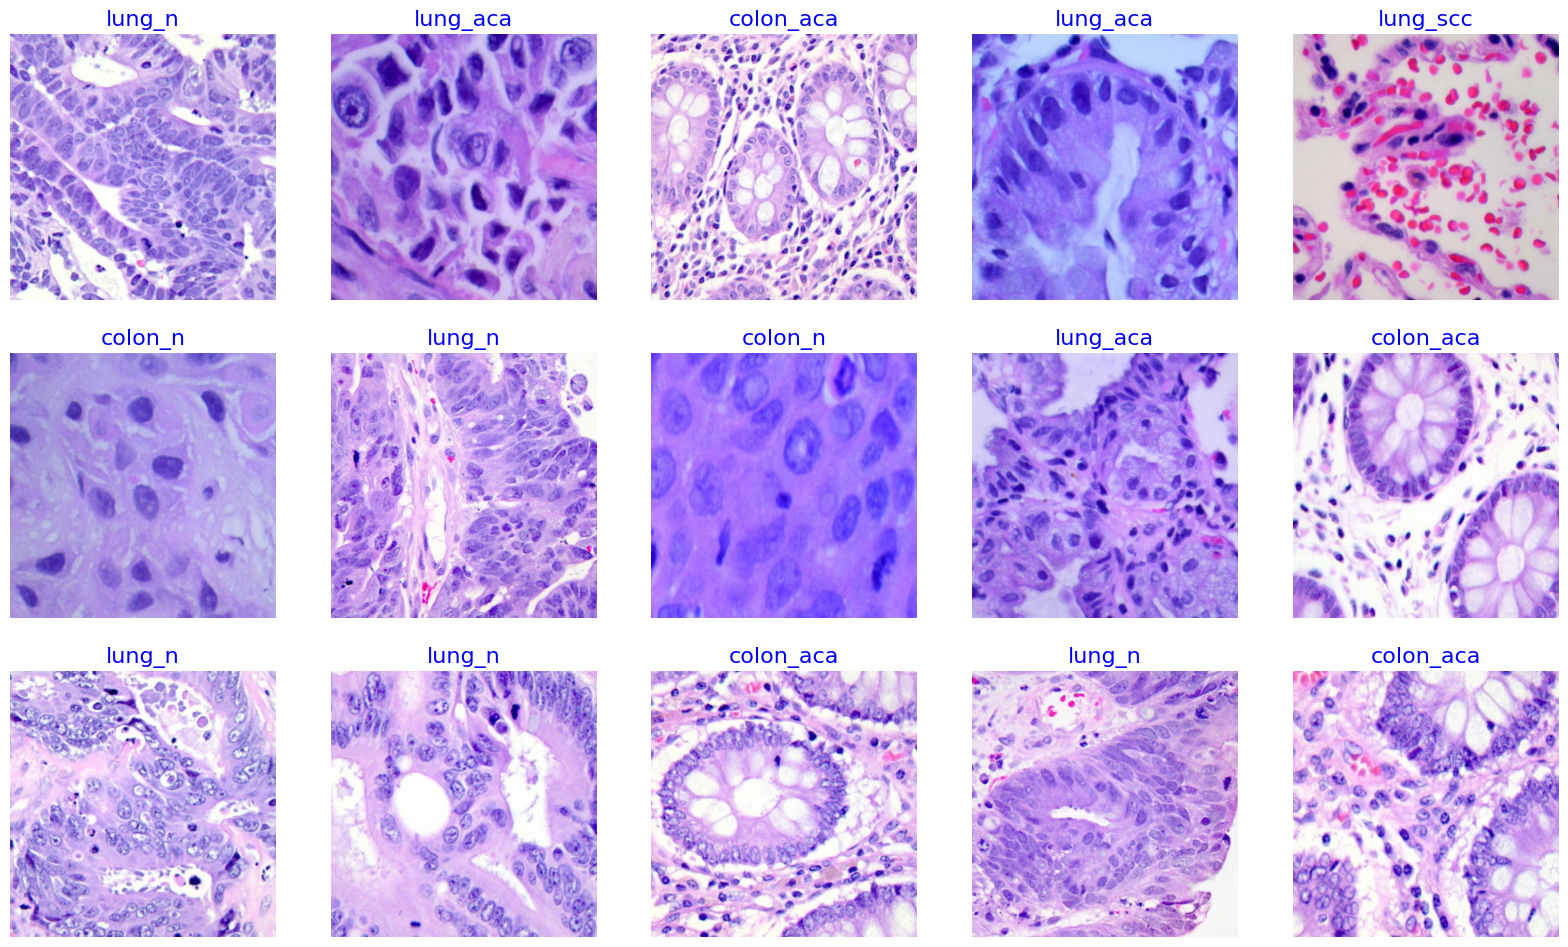

In [18]:
display_image(valid_loader,classes)

# **Batch Size Calculation Strategy**

## **Goal**
Find the optimal batch size for test data processing by ensuring:

1. **Even Distribution:** The batch size evenly divides the total samples.
2. **Batch Limit:** The number of batches does not excee

---

## **Calculation Steps**
1. **Constraints:**
   - `length % n == 0` → Ensures equal batch sizes.
   - `length / n <= 80` → Limits the number of batches.

2. **Select Batch Size:**
   - Choose the largest batch size `n` that meets bonditions.

---

## **Example**
- **Test Samples (`length`) = 1000**
- **Possible Batch Sizes:** 10, 20, 25, 50
- **Selected Batch Size:** 50 (smallember of batches).

---

## **Benefits**
- **Efficient Processing:** Fewer batches reduce overhead.
- **Memory Friendly:** Avoids overloading memory.
- **Automatic Adjustment:** Adapts to different dataset sizes.


In [19]:
from sklearn.metrics import recall_score,f1_score,precision_score,auc
from sklearn.metrics import mean_squared_error
import torchvision.models as models


In [20]:
class CombinedInceptionMobileNet(nn.Module):
    def __init__(self, num_classes):
        super(CombinedInceptionMobileNet, self).__init__()

        # 1. Load the pretrained InceptionV3 with default weights
        self.inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        # 2. Manually switch off aux_logits
        self.inception.aux_logits = False

        # 3. Load the pretrained MobileNetV2 with default weights
        self.mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

        # Freeze parameters
        for param in self.inception.parameters():
            param.requires_grad = False
        for param in self.mobilenet.parameters():
            param.requires_grad = False

        # Remove the original classification heads
        self.inception.fc = nn.Identity()
        self.mobilenet.classifier = nn.Identity()

        # Concatenate 2048 (inception) + 1280 (mobilenet) => 3328
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 1280, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x_inception = self.inception(x)  
        x_mobilenet = self.mobilenet(x)

        # Concatenate the two feature vectors
        x_combined = torch.cat([x_inception, x_mobilenet], dim=1)
        out = self.classifier(x_combined)
        return out


# Instantiate and move to device
model = CombinedInceptionMobileNet(num_classes=len(classes)).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 181MB/s] 
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.6MB/s]


In [21]:
!pip install torch-summary

In [22]:
from torch.optim import Adam
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassAUROC
from torchmetrics import MeanAbsoluteError, MeanSquaredError
from torchsummary import summary

def compile_model(model, learning_rate=0.001):
    # Define optimizer and loss function
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Define evaluation metrics (moving them to device)
    metrics = {
        'accuracy': MulticlassAccuracy(num_classes=len(classes)).to(device),
        'precision': MulticlassPrecision(num_classes=len(classes)).to(device),
        'recall': MulticlassRecall(num_classes=len(classes)).to(device),
        'auc': MulticlassAUROC(num_classes=len(classes)).to(device),
        'mae': MeanAbsoluteError().to(device),
        'mse': MeanSquaredError().to(device)
    }

    return optimizer, criterion, metrics

def print_model_summary(model, input_size):
    # Print the model architecture using torchsummary
    summary(model, input_size=input_size, device=str(device))

optimizer, criterion, metrics = compile_model(model, learning_rate=0.001)
print_model_summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                        Param #
├─Inception3: 1-1                             --
|    └─BasicConv2d: 2-1                       --
|    |    └─Conv2d: 3-1                       (864)
|    |    └─BatchNorm2d: 3-2                  (64)
|    └─BasicConv2d: 2-2                       --
|    |    └─Conv2d: 3-3                       (9,216)
|    |    └─BatchNorm2d: 3-4                  (64)
|    └─BasicConv2d: 2-3                       --
|    |    └─Conv2d: 3-5                       (18,432)
|    |    └─BatchNorm2d: 3-6                  (128)
|    └─MaxPool2d: 2-4                         --
|    └─BasicConv2d: 2-5                       --
|    |    └─Conv2d: 3-7                       (5,120)
|    |    └─BatchNorm2d: 3-8                  (160)
|    └─BasicConv2d: 2-6                       --
|    |    └─Conv2d: 3-9                       (138,240)
|    |    └─BatchNorm2d: 3-10                 (384)
|    └─MaxPool2d: 2-7                         --
|    └─InceptionA: 2-8   

In [23]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)

In [24]:
import copy

class LRA:
    def __init__(self, 
                 model, 
                 optimizer,
                 patience=9, 
                 stop_patience=3, 
                 threshold=0.9, 
                 factor=0.5, 
                 dwell=True, 
                 model_name='inceptionv3+mobilenetv2', 
                 freeze=False, 
                 initial_epoch=0, 
                 total_epochs=15):
        
        self.model = model                  # reference to the PyTorch model
        self.optimizer = optimizer          # the optimizer controlling LR
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.model_name = model_name
        self.freeze = freeze
        self.initial_epoch = initial_epoch
        self.total_epochs = total_epochs

        # Tracking variables
        self.reset = False
        self.count = 0
        self.stop_count = 0
        self.best_weights = copy.deepcopy(model.state_dict())  # store best weights
        self.lr = self._get_lr()  # current LR
        self.highest_tracc = 0.0
        self.lowest_vloss = float('inf')
        self.stop_training = False

        # Print startup info
        if freeze:
            msg = f'Starting training with base model {model_name} with weights frozen.'
        else:
            msg = f'Starting training with base model {model_name}, training all layers.'
        print_in_color(msg, (244, 252, 3), (55, 65, 80))

    def _get_lr(self):
        for param_group in self.optimizer.param_groups:
            return param_group['lr']

    def _set_lr(self, new_lr):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

    def on_epoch_begin(self, epoch):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, train_loss, train_acc, val_loss, val_acc):
        duration = time.time() - self.epoch_start_time
        lr_before = self._get_lr()

        # Decide which metric to monitor
        if train_acc < self.threshold:
            monitor = 'accuracy'  # Monitor training accuracy
            # If training accuracy improves
            if train_acc > self.highest_tracc:
                self.highest_tracc = train_acc
                self.best_weights = copy.deepcopy(self.model.state_dict())
                self.count = 0
                self.stop_count = 0
                # Update lowest_vloss if needed
                if val_loss < self.lowest_vloss:
                    self.lowest_vloss = val_loss
            else:
                # Not improved
                if self.count >= self.patience - 1:
                    # reduce LR
                    new_lr = lr_before * self.factor
                    self._set_lr(new_lr)
                    self.count = 0
                    self.stop_count += 1
                    # dwell?
                    if self.dwell:
                        self.model.load_state_dict(self.best_weights)
                else:
                    self.count += 1
        else:
            monitor = 'val_loss'  # Monitor validation loss
            if val_loss < self.lowest_vloss:
                # val_loss improved
                self.lowest_vloss = val_loss
                self.best_weights = copy.deepcopy(self.model.state_dict())
                self.count = 0
                self.stop_count = 0
            else:
                # not improved
                if self.count >= self.patience - 1:
                    new_lr = lr_before * self.factor
                    self._set_lr(new_lr)
                    self.stop_count += 1
                    self.count = 0
                    if self.dwell:
                        self.model.load_state_dict(self.best_weights)
                else:
                    self.count += 1

            # Also check if training accuracy improved (just for printout)
            if train_acc > self.highest_tracc:
                self.highest_tracc = train_acc

        lr_after = self._get_lr()

        msg = (f"{epoch+1:3d}/{self.total_epochs:3d} "
               f"TrainLoss={train_loss:.3f} TrainAcc={train_acc*100:.2f}% "
               f"ValLoss={val_loss:.3f} ValAcc={val_acc*100:.2f}% "
               f"LR={lr_before:.6f} NextLR={lr_after:.6f} "
               f"Monitor={monitor:9s} Dur={duration:.2f}s")
        print_in_color(msg, (0, 255, 255), (55, 65, 80))

        # Early stopping check
        if self.stop_count > self.stop_patience - 1:
            stop_msg = (f"Training halted at epoch {epoch+1} after "
                        f"{self.stop_patience} LR adjustments with no improvement.")
            print_in_color(stop_msg, (0, 255, 0), (55, 65, 80))
            self.stop_training = True

In [25]:
def train_model(model, 
                train_loader, 
                valid_loader,
                optimizer,
                criterion,
                lra,           # our LRA object
                num_epochs=15):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        # ----------------------
        #  Training Phase
        # ----------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        lra.on_epoch_begin(epoch)  # mimic Keras callback

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # stats
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # ----------------------
        #  Validation Phase
        # ----------------------
        model.eval()
        running_val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = running_val_loss / val_total
        epoch_val_acc = val_correct / val_total

        # Update LRA (mimic on_epoch_end)
        lra.on_epoch_end(epoch,
                         train_loss=epoch_train_loss,
                         train_acc=epoch_train_acc,
                         val_loss=epoch_val_loss,
                         val_acc=epoch_val_acc)

        # Store for plotting
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Early stopping check
        if lra.stop_training:
            break

    # After training, optionally load best weights if we want final best
    model.load_state_dict(lra.best_weights)

    # Return training history
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }
    return history

In [26]:
def tr_plot(history, start_epoch=0):
    tacc = history['train_acc']
    tloss = history['train_loss']
    vacc = history['val_acc']
    vloss = history['val_loss']

    epochs = range(start_epoch+1, len(tacc)+start_epoch+1)

    # Identify best epochs
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    sc_label = 'best epoch= ' + str(index_loss+1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc+1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    plt.style.use('fivethirtyeight')

    # --- Loss ---
    axes[0].plot(epochs, tloss, 'r', label='Training loss')
    axes[0].plot(epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss+1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # --- Accuracy ---
    axes[1].plot(epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc+1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [27]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_acc = correct / total
    return test_loss, test_acc

In [28]:
def predict_model(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # shape [batch_size, num_classes]
            all_preds.extend(probs.cpu().numpy())
    return np.array(all_preds)

In [29]:
def print_info(test_loader, 
               all_preds,   
               classes,
               print_code=0):
    """
    - Show misclassified samples 
    - Show confusion matrix
    - Show classification report
    """
    file_names = test_loader.dataset.filepaths
    true_labels = test_loader.dataset.labels  # numeric
    class_indices = {cls_name: i for i, cls_name in enumerate(classes)}

    # Get predicted class index from the probabilities
    pred_indices = np.argmax(all_preds, axis=1)

    error_list = []
    true_class_list = []
    pred_class_list = []
    prob_list = []

    # Identify misclassifications
    for i in range(len(true_labels)):
        true_idx = true_labels[i]
        pred_idx = pred_indices[i]
        if pred_idx != true_idx:
            error_list.append(file_names[i])
            true_class_list.append(classes[true_idx])
            pred_class_list.append(classes[pred_idx])
            prob_list.append(all_preds[i][pred_idx])

    errors = len(error_list)
    if print_code != 0:
        if errors > 0:
            r = min(print_code, errors)
            # Print header
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format(
                'Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                fname = os.path.split(error_list[i])[-1]
                line = '{0:^28s}{1:^28s}{2:^28s}{3:9.4f}'.format(
                    fname, pred_class_list[i], true_class_list[i], prob_list[i])
                print_in_color(line, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'With accuracy of 100% there are no errors to print.'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))

    # Confusion Matrix and Classification Report
    y_true = np.array(true_labels)
    y_pred = np.array(pred_indices)

    cm = confusion_matrix(y_true, y_pred)
    length = len(classes)
    fig_width = max(8, int(length * 0.5))
    fig_height = max(8, int(length * 0.5))

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(length)+0.5, classes, rotation=90)
    plt.yticks(np.arange(length)+0.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [30]:
model_name = 'inceptionv3+mobilenetv2'
epochs = 15
patience = 9
stop_patience = 3
threshold = 0.9
factor = 0.5
dwell = True
freeze = False

In [31]:
lra = LRA(model=model, 
          optimizer=optimizer, 
          patience=patience, 
          stop_patience=stop_patience, 
          threshold=threshold, 
          factor=factor, 
          dwell=dwell, 
          model_name=model_name, 
          freeze=freeze, 
          initial_epoch=0, 
          total_epochs=epochs)

Starting training with base model inceptionv3+mobilenetv2, training all layers.



In [32]:
history = train_model(model, 
                      train_loader=train_loader, 
                      valid_loader=valid_loader, 
                      optimizer=optimizer, 
                      criterion=criterion, 
                      lra=lra,
                      num_epochs=epochs)

  1/ 15 TrainLoss=0.204 TrainAcc=92.14% ValLoss=0.052 ValAcc=98.60% LR=0.001000 NextLR=0.001000 Monitor=val_loss  Dur=149.21s

  2/ 15 TrainLoss=0.102 TrainAcc=96.21% ValLoss=0.039 ValAcc=98.48% LR=0.001000 NextLR=0.001000 Monitor=val_loss  Dur=152.78s

  3/ 15 TrainLoss=0.080 TrainAcc=96.97% ValLoss=0.019 ValAcc=99.12% LR=0.001000 NextLR=0.001000 Monitor=val_loss  Dur=152.39s

  4/ 15 TrainLoss=0.083 TrainAcc=97.05% ValLoss=0.024 ValAcc=99.16% LR=0.001000 NextLR=0.001000 Monitor=val_loss  Dur=153.13s

  5/ 15 TrainLoss=0.071 TrainAcc=97.72% ValLoss=0.036 ValAcc=98.48% LR=0.001000 NextLR=0.001000 Monitor=val_loss  Dur=153.61s

  6/ 15 TrainLoss=0.061 TrainAcc=97.94% ValLoss=0.010 ValAcc=99.72% LR=0.001000 NextLR=0.001000 Monitor=val_loss  Dur=152.28s

  7/ 15 TrainLoss=0.051 TrainAcc=98.25% ValLoss=0.097 ValAcc=96.76% LR=0.001000 NextLR=0.001000 Monitor=val_loss  Dur=152.80s

  8/ 15 TrainLoss=0.047 TrainAcc=98.41% ValLoss=0.024 ValAcc=99.12% LR=0.001000 NextLR=0.001000 Monitor=val_los

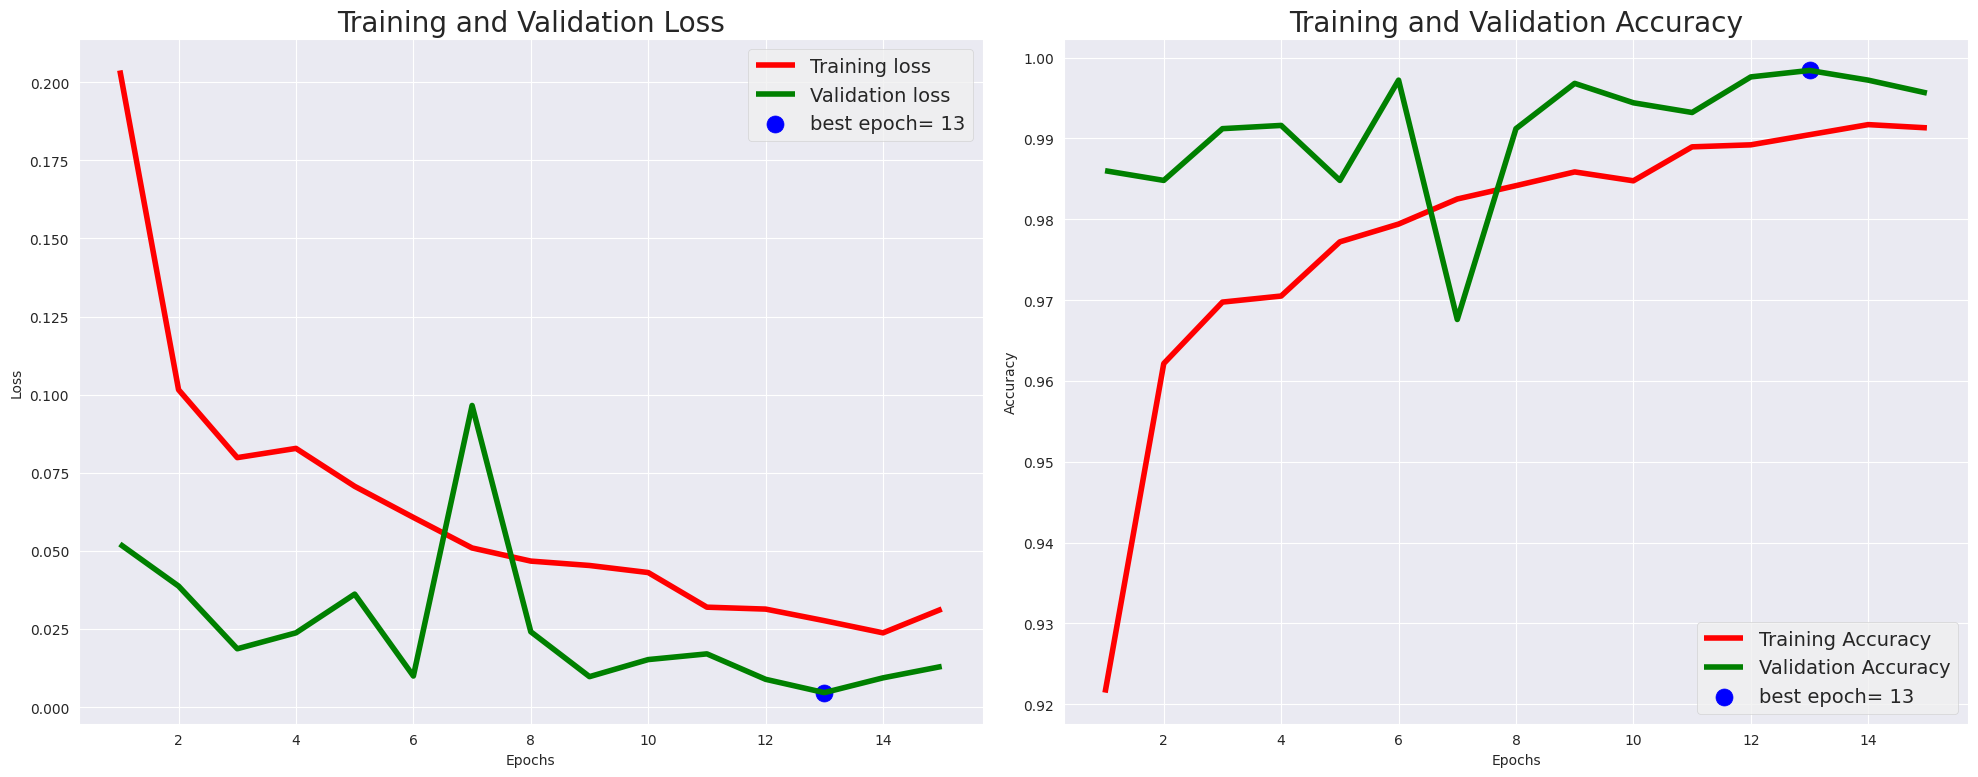

In [33]:
tr_plot(history, start_epoch=0)

In [34]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print_in_color(f"Accuracy on the test set is {test_acc*100:.2f}%", (0,255,0),(55,65,80))

Accuracy on the test set is 99.72%



In [35]:
save_id = f"{model_name}-testacc_{test_acc*100:.2f}.pth"
torch.save(model.state_dict(), os.path.join('.', save_id))

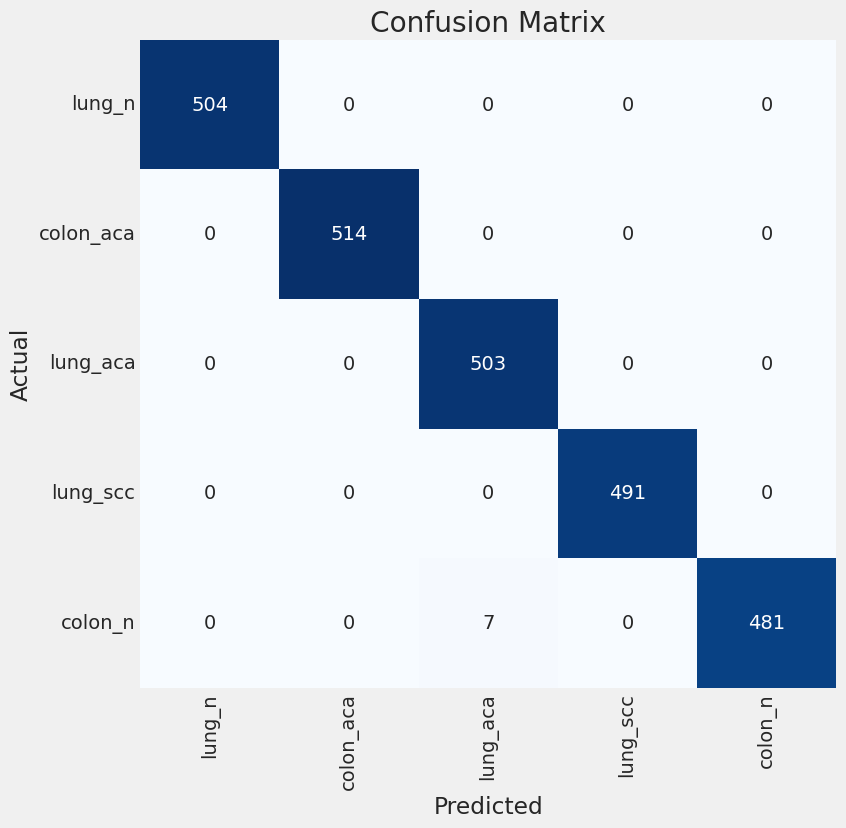

Classification Report:
----------------------
               precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       504
   colon_aca       1.00      1.00      1.00       514
    lung_aca       0.99      1.00      0.99       503
    lung_scc       1.00      1.00      1.00       491
     colon_n       1.00      0.99      0.99       488

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [36]:
all_preds = predict_model(model, test_loader)
print_info(test_loader, all_preds, classes, print_code=0)